# Modeling Returns using various Neural Networks

In [1]:
import pandas as pd
import pandas_datareader.data as web
import os
import datetime as dt

from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2020, 7, 3)
df = web.DataReader('^GSPC', 'yahoo', start, end)
df.reset_index(inplace=True)
df = df[['Date', 'Adj Close']]

In [3]:
df.set_index('Date', inplace=True)
df['log_returns'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))
df['net_returns'] = np.exp(df['log_returns']) - 1

Text(0, 0.5, 'Net Returns')

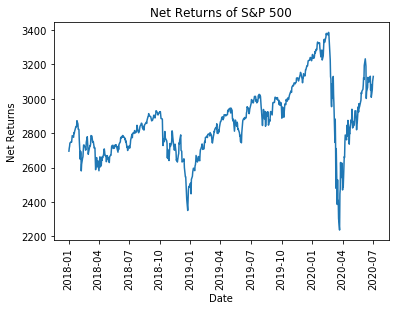

In [13]:
plt.plot(df['Adj Close'])
plt.title('Net Returns of S&P 500')
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Net Returns')

In [12]:
df['Adj Close']

Date
2018-01-02    2695.810059
2018-01-03    2713.060059
2018-01-04    2723.989990
2018-01-05    2743.149902
2018-01-08    2747.709961
2018-01-09    2751.290039
2018-01-10    2748.229980
2018-01-11    2767.560059
2018-01-12    2786.239990
2018-01-16    2776.419922
2018-01-17    2802.560059
2018-01-18    2798.030029
2018-01-19    2810.300049
2018-01-22    2832.969971
2018-01-23    2839.129883
2018-01-24    2837.540039
2018-01-25    2839.250000
2018-01-26    2872.870117
2018-01-29    2853.530029
2018-01-30    2822.429932
2018-01-31    2823.810059
2018-02-01    2821.979980
2018-02-02    2762.129883
2018-02-05    2648.939941
2018-02-06    2695.139893
2018-02-07    2681.659912
2018-02-08    2581.000000
2018-02-09    2619.550049
2018-02-12    2656.000000
2018-02-13    2662.939941
                 ...     
2020-05-21    2948.510010
2020-05-22    2955.449951
2020-05-26    2991.770020
2020-05-27    3036.129883
2020-05-28    3029.729980
2020-05-29    3044.310059
2020-06-01    3055.729980
2020-06

In [36]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [41]:
n_steps = 5 # Predict on past 5 values
# split into samples
X, y = split_sequence(df['Adj Close'], n_steps)
X.shape

(625, 5)

In [42]:
# reshape from [samples, n_steps] into [samples, n_steps, features]
n_features = 1
X = X.reshape((X.shape[0], n_steps, n_features))
X.shape

(625, 5, 1)

In [46]:
batch_size = 64 # optimizer after every 64 datapoints

# Create LSTM NN archhitecture

inputs = Input(batch_shape=(batch_size, n_steps, n_features))
layer1 = LSTM(50, 
              stateful=True, 
              return_sequences=True)(inputs)
layer2 = LSTM(50,
              stateful=True,
              return_sequences=True)(layer1)
outputs = Dense(units = 1)(layer2)

model = Model(inputs=inputs,
              outputs=outputs)

# Optimizers
opt = Adam(learning_rate=0.01,
           epsilon=1e-3)

model.compile(optimizer=opt,
              loss = 'mse')

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (64, 5, 1)                0         
_________________________________________________________________
lstm_5 (LSTM)                (64, 5, 50)               10400     
_________________________________________________________________
lstm_6 (LSTM)                (64, 5, 50)               20200     
_________________________________________________________________
dense_3 (Dense)              (64, 5, 1)                51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.fit(X, y)

ValueError: Error when checking target: expected dense_3 to have 3 dimensions, but got array with shape (625, 1)